<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/04%20investment%20portfolios%20with%20DCF.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

You can run the code examples in [Google Colab](https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/03%20investment%20portfolios.ipynb).

**To install the package:**

In [84]:
# !pip install okama

import okama and matplotlib packages ...

In [85]:
import warnings

import matplotlib.pyplot as plt

import okama as ok

plt.rcParams["figure.figsize"] = [12.0, 6.0]
warnings.simplefilter(action="ignore", category=FutureWarning)

In [86]:
ok.__version__

'1.4.3'

Сlass **Portfolio** can be used to define the basic investment strategy (without cash flow).

In [87]:
pf = ok.Portfolio(
    ["SPY.US", "AGG.US", "GLD.US"],
    weights=[0.60, 0.35, 0.05],
    ccy="USD",
    inflation=True,
    last_date="2024-01",
    rebalancing_period="year",
    symbol="My_portfolio.PF"
)
pf

symbol                         My_portfolio.PF
assets                [SPY.US, AGG.US, GLD.US]
weights                      [0.6, 0.35, 0.05]
rebalancing_period                        year
currency                                   USD
inflation                             USD.INFL
first_date                             2004-12
last_date                              2024-01
period_length               19 years, 2 months
dtype: object

## Set up Cash Flow strategy

Cash flow parameters for investment portfolios can be configured in the corresponding classes:

- `IndexationStrategy` for strategies with regular indexed withdrawals / contributions
- `PercentageStrategy` for strategies weith regualr fixed percentage withdrawals / contributions
- `TimeSeriesStrategy` for strategies with user-defined withdrawals and contributions. Withdrawals, contributions, as well as their dates, are defined in the dictionary.

### Cash flow strategy with regular indexed withdrawals or contributions

`IndexationStrategy` class can be used to set up a cash flow strategy where contributions or withdrawals to portfolio are made with a certain frequency.  All contributions can be indexed each period.

`pf.dcf.weatlh_index`

In [88]:
ind = ok.IndexationStrategy(pf) # create IndexationStrategy linked to the Portfolio

Set up the cash flow parameters.

In [89]:
ind.initial_investment = 10_000  # the initial investments size
ind.amount = -2_500  # set withdrawal size
ind.frequency = "year"  # set cash flow frequency
ind.indexation = "inflation"  # set indexation equal to mean inflation
ind

Portfolio symbol                My_portfolio.PF
Cash flow initial investment              10000
Cash flow frequency                        year
Cash flow strategy                 fixed_amount
Cash flow amount                          -2500
Cash flow indexation                   0.025322
dtype: object

Assign the strategy to Portfolio.

In [90]:
pf.dcf.cashflow_parameters = ind

## Backtest the Portfolio with cash flow

We can start by verifying the strategy on historical data. 

<Axes: xlabel='date'>

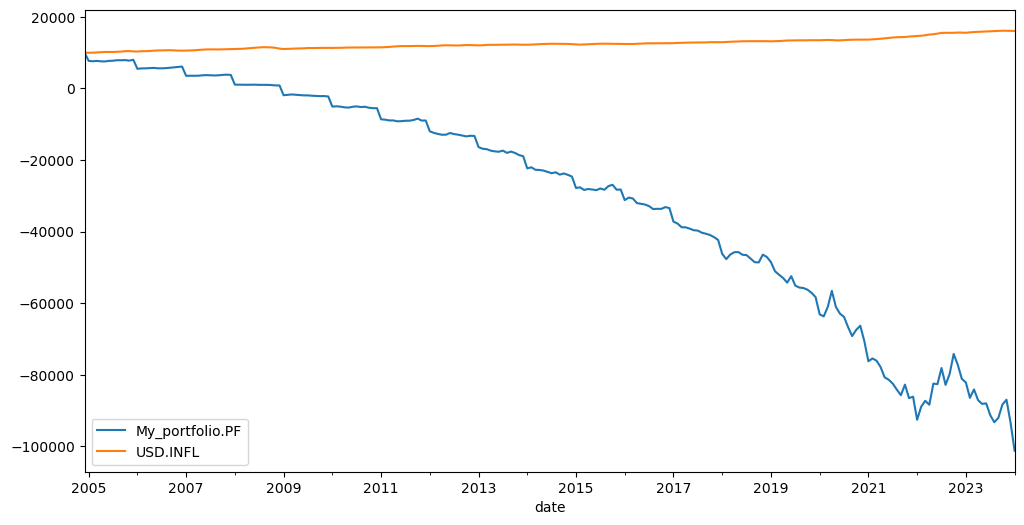

In [91]:
pf.dcf.wealth_index.plot()

It's easy to see that the portfolio balance is voided fast. The "survival period" is 4.2 years. The withdrawal size is too big.

In [92]:
pf.dcf.survival_period_hist()

4.2

To get the date of when the portfolio balance reduced to 0 we can use `survival_date_hist()`

In [93]:
pf.dcf.survival_date_hist()

Timestamp('2009-01-31 00:00:00')

Let's change the withdrawal size...

In [94]:
pf.dcf.cashflow_parameters.amount = -500

<Axes: xlabel='date'>

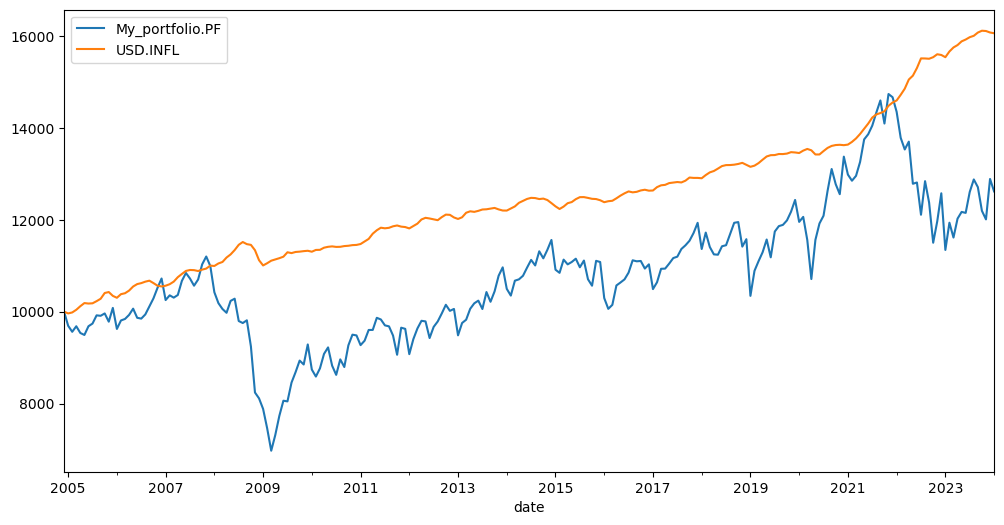

In [95]:
pf.dcf.wealth_index.plot()

The size of the initial investment in 2004 (the beginning of the historical data period) is 10,000. However, the purchasing power of money 20 years ago was different. The discounted size of the initial investment can be found with `initial_investment_pv`:

In [96]:
pf.dcf.initial_investment_pv

6202.551468209303

If we want to start backtesting a strategy with a discounted initial investment and withdrawal amount, then it is enough to change the value of the `use_discounted_values` parameter.

In [97]:
pf.dcf.use_discounted_values = True

<Axes: xlabel='date'>

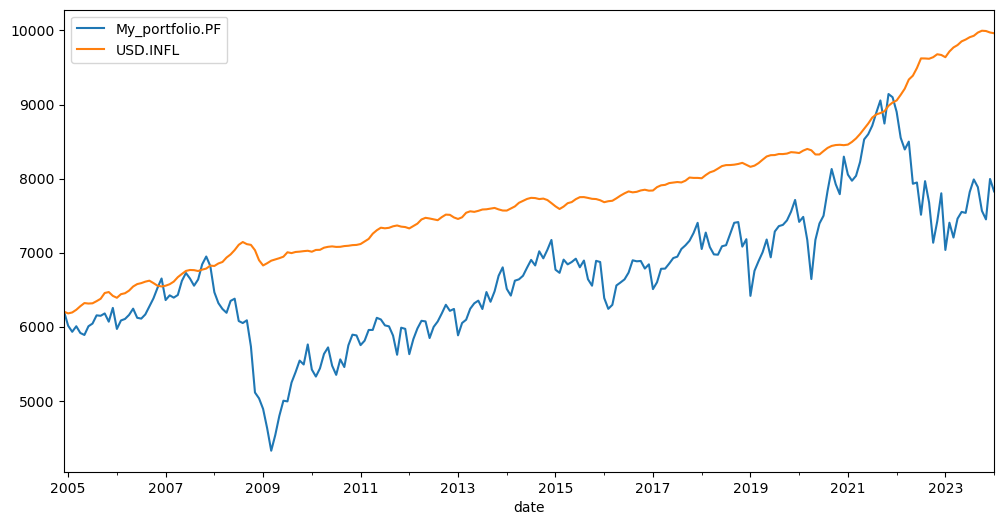

In [98]:
pf.dcf.wealth_index.plot()

When the withdrawal size -500 (5% of the initial investments) the portfolio balance lasts for 19 years of backtest period. But will it work in the future? Is it an optimal withdrawal size?